In [2]:
import torch
from torchvision import datasets
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [3]:
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True)
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False)

In [4]:
x_train = torch.stack([x for x in trainset.data]).float()
y_train = torch.stack([y for y in trainset.targets])
x_test = torch.stack([x for x in testset.data]).float()
y_test = torch.stack([y for y in testset.targets])

x_train.shape, y_train.shape, x_test.shape, y_test.shape

(torch.Size([60000, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000, 28, 28]),
 torch.Size([10000]))

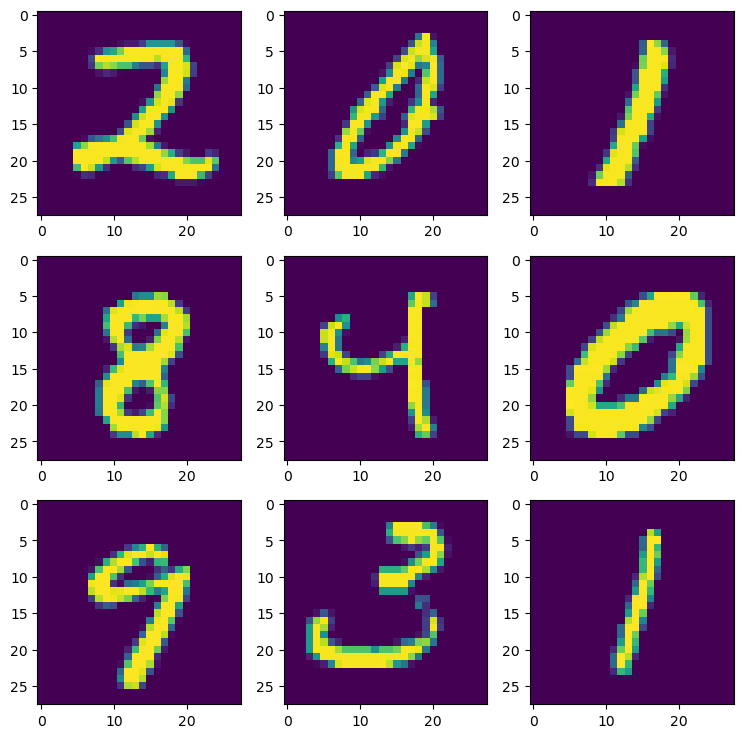

In [5]:
fig, axs = plt.subplots(3, 3, figsize=(9, 9))
axs = axs.ravel()

for i, j in enumerate(torch.randint(0, 60000, (9,))):
    axs[i].imshow(x_train[int(j)])
plt.show()

In [6]:
n_classes = len(set([y.item() for y in y_train]))

x_train_r = x_train.view(x_train.shape[0], -1)
x_test_r = x_test.view(x_test.shape[0], -1)

print(x_train_r.shape, x_test_r.shape, y_train.shape, y_test.shape)

n_samples = x_train_r.shape[0]
n_features = x_train_r.shape[1]

print(n_samples, n_features, n_classes)

torch.Size([60000, 784]) torch.Size([10000, 784]) torch.Size([60000]) torch.Size([10000])
60000 784 10


In [7]:
# Initialise

# worth noting that keras and pytorch initialise normal distributions slightly differently (before gain and adjustments)
# keras uses truncated normal distribution while pytorch uses unmodified normal distribution
# below I am going with pytorch method and initialising a standard normal distribution

layer1_size = 512
layer2_size = 256

W1 = torch.nn.init.xavier_normal_(torch.empty(n_features, layer1_size))
b1 = torch.zeros(layer1_size)
W2 = torch.nn.init.xavier_normal_(torch.empty(layer1_size, layer2_size))
b2 = torch.zeros(layer2_size)
W3 = torch.nn.init.xavier_normal_(torch.empty(layer2_size, n_classes))
b3 = torch.zeros(n_classes)

parameters = [W1, b1, W2, b2, W3, b3]
for p in parameters:
    p.requires_grad = True

print(sum(p.numel() for p in parameters))

535818


In [16]:
EPOCHS = 100
BATCH_SIZE = 128

losses = []
accuracies = []

for epoch in range(EPOCHS):
    print(f"Training Epoch {epoch+1}")
    epoch_loss = []
    epoch_acc = []
    
    batches = torch.split(torch.randperm(n_samples), BATCH_SIZE)

    for batch_idx in batches:
        
        x_batch, y_batch = x_train_r[batch_idx], y_train[batch_idx]

        layer1_logits = x_batch @ W1 + b1
        layer1_outputs = layer1_logits.tanh()
        layer2_logits = layer1_outputs @ W2 + b2
        layer2_outputs = layer2_logits.tanh()
        layer3_logits = layer2_outputs @ W3 + b3

        loss = F.cross_entropy(layer3_logits, y_batch)


        pred = torch.argmax(F.softmax(layer3_logits, dim=1), dim=1)
        accuracy = (pred == y_batch).float().mean()
        epoch_acc.append(accuracy)
        
        epoch_loss.append(loss)

        for p in parameters:
            p.grad = None
        loss.backward()

        for p in parameters:
            p.data += -0.01 * p.grad

    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    losses.append(epoch_loss.item())
    print(f"     Loss is {epoch_loss.item()}")

    epoch_acc = sum(epoch_acc) / len(epoch_acc)
    accuracies.append(epoch_acc.item())
    print(f"     Accuracy is {epoch_acc.item()*100:.2f}")

Training Epoch 1
     Loss is 0.58503258228302
     Accuracy is 83.61
Training Epoch 2
     Loss is 0.3153229057788849
     Accuracy is 91.08
Training Epoch 3
     Loss is 0.26302456855773926
     Accuracy is 92.49
Training Epoch 4
     Loss is 0.23087190091609955
     Accuracy is 93.44
Training Epoch 5
     Loss is 0.21238070726394653
     Accuracy is 93.92
Training Epoch 6
     Loss is 0.19385072588920593
     Accuracy is 94.53
Training Epoch 7
     Loss is 0.17904505133628845
     Accuracy is 94.89
Training Epoch 8
     Loss is 0.17264001071453094
     Accuracy is 95.01
Training Epoch 9
     Loss is 0.16039618849754333
     Accuracy is 95.35
Training Epoch 10
     Loss is 0.15178611874580383
     Accuracy is 95.60
Training Epoch 11
     Loss is 0.14692994952201843
     Accuracy is 95.76
Training Epoch 12
     Loss is 0.14253340661525726
     Accuracy is 95.84
Training Epoch 13
     Loss is 0.13612119853496552
     Accuracy is 95.99
Training Epoch 14
     Loss is 0.12992195785045624


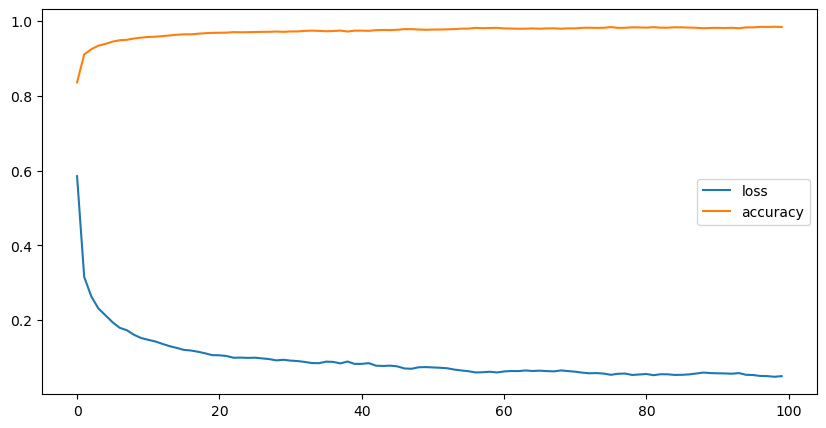

In [17]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(losses, label='loss')
ax.plot(accuracies, label='accuracy')
ax.legend()

plt.show()

In [18]:
with torch.no_grad():
    layer1_logits = x_test_r @ W1 + b1
    layer1_outputs = layer1_logits.tanh()
    layer2_logits = layer1_outputs @ W2 + b2
    layer2_outputs = layer2_logits.tanh()
    layer3_logits = layer2_outputs @ W3 + b3

    pred = torch.argmax(F.softmax(layer3_logits, dim=1), dim=1)
    accuracy = (pred == y_test).float().mean()
    loss = F.cross_entropy(layer3_logits, y_test)
    
    print(f"Test Loss is {loss.item()}")
    print(f"Test Accuracy is {accuracy.item()*100:.2f}")

Test Loss is 0.10327557474374771
Test Accuracy is 96.92
